# Imports

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [2]:
import sklearn
from sklearn import set_config

In [3]:
sklearn.__version__

'1.2.0'

# Global Configuration

In [4]:
set_config(transform_output="pandas")

In [5]:
CWD = os.getcwd()
PATH_INPUT = os.path.join(CWD, "input")
PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")

In [6]:
os.listdir(CWD)

['.DS_Store',
 'requirements.txt',
 'Benchmark_20240328.ipynb',
 'input',
 'venvs',
 'submission.csv',
 'Benchmark_20240329.ipynb',
 '2104203884-734476011-3058cb37-b96a-458a-9087-5d1085783958.mp4',
 '.ipynb_checkpoints']

In [7]:
os.listdir(PATH_INPUT)

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']

# Helper functions

In [8]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Dataset loading

In [9]:
X, _ = load_data()

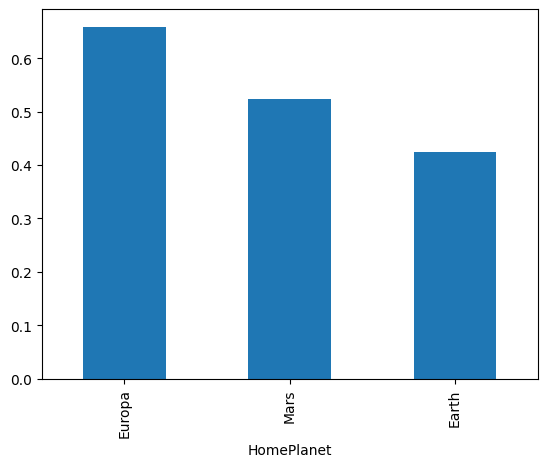

In [10]:
(
    X
    .groupby("HomePlanet")
    ["Transported"]
    .mean()
    .sort_values(ascending = False)
    .plot(kind = "bar")
);

In [11]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [12]:
_ = (
    X
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr_rows = ("Cabin", len),
        transported_ratio = ("Transported", np.mean)
    )
    .assign(
        nr_rows_pct = lambda df: round((df["nr_rows"]/df["nr_rows"].sum())*100, 2),
        transported_ratio = lambda df: round(df["transported_ratio"] * 100, 2)
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_1544/1725775422.py:2: FutureWarning: The provided callable <function mean at 0x1043b9550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [13]:
_

nr_rows  transported_ratio  nr_rows_pct
HomePlanet CryoSleep                                         
Earth      False         3106              32.10        37.53
           True          1382              65.63        16.70
Europa     False         1162              40.02        14.04
           True           911              98.90        11.01
Mars       False         1047              27.70        12.65
           True           669              91.18         8.08

In [14]:
X["LenCabin"] = X["Cabin"].apply(lambda cabin: len(str(cabin)))

In [15]:
X.groupby(["LenCabin"]).size()

LenCabin
3     199
5     130
6    1201
7    5043
8    2120
dtype: int64

In [16]:
X[X["LenCabin"] == 5].head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5


In [17]:
X["Cabin"].fillna("NA", inplace = True)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_1544/3468940878.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Cabin"].fillna("NA", inplace = True)


In [18]:
# X["Cabin"]

In [19]:
X["CabinFirstLetter"] = X["Cabin"].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)

In [20]:
X["CabinFirstLetter"].value_counts().sort_index()

CabinFirstLetter
A      256
B      779
C      747
D      478
E      876
F     2794
G     2559
NA     199
T        5
Name: count, dtype: int64

In [21]:
(
    X
    .groupby(["CabinFirstLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinFirstLetter
A     0.496094
B     0.734275
C     0.680054
D     0.433054
E     0.357306
F     0.439871
G     0.516217
NA    0.502513
T     0.200000
Name: Transported, dtype: float64

In [22]:
X.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,LenCabin
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,6.984240
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.898869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,7.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [23]:
X.isnull().sum()

HomePlanet          201
CryoSleep           217
Cabin                 0
Destination         182
Age                 179
VIP                 203
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Name                200
Transported           0
LenCabin              0
CabinFirstLetter      0
dtype: int64

In [24]:
X.shape

(8693, 15)

In [25]:
del X, _

# Preprocessing and Modelling

In [26]:
X_train, X_test = load_data()

In [27]:
y = X_train.pop("Transported")

In [28]:
X_train.select_dtypes(exclude=np.number).columns.tolist()

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']

In [29]:
class CabinTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)

In [30]:
ct_impute = ColumnTransformer(
    transformers = [
        ("impute_numerical", SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.number)),
        ("impute_cabin", SimpleImputer(strategy="constant", fill_value="NA"), ["Cabin"]),
        (
            "impute_categorical",
            SimpleImputer(strategy="most_frequent"),
            ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name']
        )
    ],
    remainder = 'passthrough'
)

In [31]:
ct_impute

ColumnTransformer(remainder='passthrough',
                  transformers=[('impute_numerical', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x179830eb0>),
                                ('impute_cabin',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Cabin']),
                                ('impute_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'Name'])])

In [32]:
Xt = ct_impute.fit_transform(X_train)

In [33]:
Xt.head()

,impute_numerical__Age,impute_numerical__RoomService,impute_numerical__FoodCourt,impute_numerical__ShoppingMall,impute_numerical__Spa,impute_numerical__VRDeck,impute_cabin__Cabin,impute_categorical__HomePlanet,impute_categorical__CryoSleep,impute_categorical__Destination,impute_categorical__VIP,impute_categorical__Name
PassengerId,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,B/0/P,Europa,False,TRAPPIST-1e,False,Maham Ofracculy
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,F/0/S,Earth,False,TRAPPIST-1e,False,Juanna Vines
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,A/0/S,Europa,False,TRAPPIST-1e,True,Altark Susent
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,A/0/S,Europa,False,TRAPPIST-1e,False,Solam Susent
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,F/1/S,Earth,False,TRAPPIST-1e,False,Willy Santantines


In [34]:
CabinTransformer().fit_transform(Xt["impute_cabin__Cabin"]).value_counts().sort_index()

impute_cabin__Cabin
A      256
B      779
C      747
D      478
E      876
F     2794
G     2559
NA     199
T        5
Name: count, dtype: int64

In [35]:
CabinTransformer().transform(ct_impute.transform(X_test)["impute_cabin__Cabin"]).value_counts().sort_index()

impute_cabin__Cabin
A       98
B      362
C      355
D      242
E      447
F     1445
G     1222
NA     100
T        6
Name: count, dtype: int64

In [36]:
fu_age = FeatureUnion(
    transformer_list = [
        ("fe_age_12", Binarizer(threshold=12)),
        ("fe_age_18", Binarizer(threshold=18)),
        ("fe_age_pass", "passthrough")       
    ]
)

In [37]:
ct_fe = ColumnTransformer(
    transformers = [
        ("fu_age", fu_age, ["impute_numerical__Age"]),
        ("pass", "passthrough", [1, 2, 3, 4, 5]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep", "impute_categorical__VIP"]
        )
    ],
    remainder = "drop"
)

In [38]:
ct_fe

ColumnTransformer(transformers=[('fu_age',
                                 FeatureUnion(transformer_list=[('fe_age_12',
                                                                 Binarizer(threshold=12)),
                                                                ('fe_age_18',
                                                                 Binarizer(threshold=18)),
                                                                ('fe_age_pass',
                                                                 'passthrough')]),
                                 ['impute_numerical__Age']),
                                ('pass', 'passthrough', [1, 2, 3, 4, 5]),
                                ('ohe', OneHotEncoder(sparse_output=False),
                                 ['impute_categorical__HomePlanet',
                                  'impute_categorical__CryoSleep',
                                  'impute_categorical__VIP'])])

("cabin_fe", make_column_transformer(
    (
        CabinTransformer(), ["impute_cabin__Cabin"])
    )
),

In [39]:
pipe = Pipeline(
    steps = [
        ("impute", ct_impute),
        ("fe", ct_fe),
        ("model", DecisionTreeClassifier(max_depth=4))
    ]
)

In [40]:
pipe

Pipeline(steps=[('impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x179830eb0>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet'...
                                                  FeatureUnion(transformer_list=[('fe_age_12',
                                                                                  Binarizer(threshold=12)),
                                                                                 ('fe_age_18',
                                                                                  Binarizer(threshold=18)),
                                                                                 ('fe_age_pass',
                                                                                  'passthrough')]),
                                                  ['impute_numerical__Age']),
                                                 ('pass', 'passthrough',
                                                  [1, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['impute_categorical__HomePlanet',
                                                   'impute_categorical__CryoSleep',
                                                   'impute_categorical__VIP'])])),
                ('model', DecisionTreeClassifier(max_depth=4))])

In [41]:
pipe[:2].fit_transform(X_train).head()

,fu_age__fe_age_12__impute_numerical__Age,fu_age__fe_age_18__impute_numerical__Age,fu_age__fe_age_pass__impute_numerical__Age,pass__impute_numerical__RoomService,pass__impute_numerical__FoodCourt,pass__impute_numerical__ShoppingMall,pass__impute_numerical__Spa,pass__impute_numerical__VRDeck,ohe__impute_categorical__HomePlanet_Earth,ohe__impute_categorical__HomePlanet_Europa,ohe__impute_categorical__HomePlanet_Mars,ohe__impute_categorical__CryoSleep_False,ohe__impute_categorical__CryoSleep_True,ohe__impute_categorical__VIP_False,ohe__impute_categorical__VIP_True
PassengerId,,,,,,,,,,,,,,,
0001_01,1.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
0002_01,1.0,1.0,24.0,109.0,9.0,25.0,549.0,44.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
0003_01,1.0,1.0,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
0003_02,1.0,1.0,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
0004_01,1.0,0.0,16.0,303.0,70.0,151.0,565.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [42]:
y.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [43]:
_ = cross_val_score(estimator=pipe, X=X_train, y=y, cv=10)

In [44]:
# Benchmark -             0.7234581961033293
# New Model con OHE -     0.7155214740155814
# New Model con 4 depth - 0.764529582159438

np.mean(_)

0.7648752033649457

In [45]:
_

array([0.74827586, 0.73448276, 0.75172414, 0.76064442, 0.7433832 ,
       0.79171461, 0.78711162, 0.79056387, 0.7721519 , 0.76869965])

In [46]:
pipe.fit(X_train, y)

Pipeline(steps=[('impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x179830eb0>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet'...
                                                  FeatureUnion(transformer_list=[('fe_age_12',
                                                                                  Binarizer(threshold=12)),
                                                                                 ('fe_age_18',
                                                                                  Binarizer(threshold=18)),
                                                                                 ('fe_age_pass',
                                                                                  'passthrough')]),
                                                  ['impute_numerical__Age']),
                                                 ('pass', 'passthrough',
                                                  [1, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['impute_categorical__HomePlanet',
                                                   'impute_categorical__CryoSleep',
                                                   'impute_categorical__VIP'])])),
                ('model', DecisionTreeClassifier(max_depth=4))])

In [47]:
y_pred = pipe.predict(X_test)

# Submission a Kaggle

In [48]:
X_test_copy = X_test.copy(deep = True)

In [49]:
X_test_copy["Transported"] = list(map(bool, y_pred))

In [50]:
X_test_copy.reset_index()[["PassengerId", "Transported"]].to_csv("submission.csv", index=False)